# 긍정,부정 학습

## 데이터 준비

* 네이버쇼핑 리뷰로 학습시키기

In [ ]:
import urllib.request as req
req.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f631b09fd10>)

In [ ]:
# DataFrame으로 로드

import pandas as pd
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 200000


In [ ]:
import numpy as np
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복을 제외한 샘플의 수
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
# 훈련용 데이터와 테스트용 데이터를 나눔
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# 형태소 분석기 설치 - Mecab
!pip install konlpy

!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

import os
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.1.tar.gz
!tar zxfv mecab-0.996-ko-0.9.1.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.1')
!./configure
!make
!make check
!make install

import os
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.0.1-20150920.tar.gz
!tar -zxvf mecab-ko-dic-2.0.1-20150920.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.0.1-20150920')
!./autogen.sh
!./configure
!make
# !sh -c 'echo "dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic" > /usr/local/etc/mecabrc'
!make install

# install mecab-python
import os
os.chdir('/content')

!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')

!python3 setup.py build
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 59.8 MB/s 
     |████████████████████████████████| 453 kB 35.0 MB/s 
Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic In

In [ ]:
from konlpy.tag import Mecab

#train, test 데이터에 Mecab을 사용하여 토큰화 작업 중 '의', '이' 등 필요없는 토큰 삭제
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '것', '과', '와', '네', '들', '듯', '지', '임', '게'
'네요', '어요', '는데', '있', '했', '거', '어', '아요', '습니다', '아요', '있', '는데', '합니다', '먹', '재', '같', '너무', '같', '어']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
#긍정과 부정 단어들을 저장하는 리스트 생성
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
from collections import Counter

#부정적인 단어들 중 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31802), ('안', 19723), ('게', 11480), ('좋', 9826), ('배송', 9624), ('구매', 8893), ('없', 8683), ('그냥', 8350), ('되', 8325), ('잘', 8033), ('않', 7965), ('나', 7534), ('요', 6988), ('만', 6649), ('로', 6282), ('기', 6163), ('쓰', 5886), ('아서', 5824), ('해서', 5655), ('주', 5640)]


In [ ]:
#긍정적인 단어들 중 빈도수가 높은 상위 20개 단어 출력

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39477), ('네요', 19708), ('잘', 18607), ('구매', 16174), ('배송', 12253), ('게', 11894), ('ㅎ', 10064), ('만족', 7209), ('쓰', 6289), ('아', 6170), ('기', 6002), ('사용', 5846), ('요', 5542), ('해서', 5492), ('았', 5408), ('빠르', 5226), ('해요', 5220), ('되', 5164), ('지만', 4974), ('가격', 4940)]


In [ ]:
#train, test set에 저장

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#기계가 텍스트를 숫자로 처리할 수 있도록 정수 인코딩
#토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
#등장 횟수가 1인 단어들 배제하기 위해 단어들의 비중 검색

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40263
등장 빈도가 1번 이하인 희귀 단어의 수: 18600
단어 집합에서 희귀 단어의 비율: 46.19625959317488
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9139056642988648


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)
print(X_train)

단어 집합의 크기 : 21665
[list(['사이즈', '센치', '씩', '늘린', '건데', '작', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋'])
 list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요'])
 list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶'])
 ... list(['장', '주문', '안', '됩니다', '장', '가능', '해요'])
 list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', 'ㅋㅋ'])
 list(['조금', '약해', '보이', '저렴', '게', '잘', '삿', '요'])]


In [ ]:
# 텍스트를 숫자로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])
print(X_test[:3])

[[54, 2032, 286, 14194, 248, 61, 223, 155, 124, 788, 2974, 611, 2, 65, 50, 194, 28, 1341, 140, 3], [469, 401, 41, 8462, 2572, 2189, 322, 2901, 232, 2411, 26, 458, 2], [33, 11, 808, 93, 24, 2365, 145, 4, 6, 7976, 1305, 17, 128, 305, 29, 47, 145, 128, 4, 1913, 2, 99, 144, 1372, 303, 107, 123]]
[[688, 757, 104, 170, 231], [322, 3889, 50, 3750, 1639], [8, 59, 2, 38, 152, 3, 497, 275, 80, 97, 551, 47, 4, 2]]


In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 84
리뷰의 평균 길이 : 13.5743842167397


In [ ]:
# 텍스트를 숫자로 변환

from tensorflow.keras.preprocessing.sequence import pad_sequences

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
# GRU를 이용하여 감성 분석(데이터를 학습시킴)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2813 - acc: 0.8928
Epoch 1: val_acc improved from -inf to 0.90833, saving model to best_model.h5
2000/2000 [==============================] - 322s 158ms/step - loss: 0.2813 - acc: 0.8928 - val_loss: 0.2457 - val_acc: 0.9083
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2243 - acc: 0.9179
Epoch 2: val_acc improved from 0.90833 to 0.91873, saving model to best_model.h5
2000/2000 [==============================] - 296s 148ms/step - loss: 0.2243 - acc: 0.9179 - val_loss: 0.2215 - val_acc: 0.9187
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2069 - acc: 0.9257
Epoch 3: val_acc improved from 0.91873 to 0.91910, saving model to best_model.h5
2000/2000 [==============================] - 302s 151ms/step - loss: 0.2069 - acc: 0.9257 - val_loss: 0.2191 - val_acc: 0.9191
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1949 - acc: 0.9304
Epoch 4

In [ ]:
from tensorflow.keras.models import load_model

#테스트 정확도 출력
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 38s 24ms/step - loss: 0.2207 - acc: 0.9202

 테스트 정확도: 0.9202


In [ ]:
positive_data = []
negative_data = []

def sentiment_predict(new_sentence):
  print(new_sentence)
  sentence_noun = mecab.nouns(new_sentence)
    
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    positive_data.append(sentence_noun)
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    negative_data.append(sentence_noun)

# 데이터 긍정,부정 분석

In [ ]:
#긍정, 부정의 비율을 알기 위해 긍정, 부정 데이터의 개수 저장
positive_ave=[]
negative_ave=[]

#각각 긍정, 부정데이터에서의 빈출 단어를 출력하기 위한 list
positive_data=[]
negative_data=[]

#학습된 데이터를 가지고 리뷰가 긍정인지 부정인지 예측
def sentiment_predict(new_sentence):
  print(new_sentence)
  sentence_noun=mecab.nouns(new_sentence)
    
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    positive_ave.append(score * 100)
    positive_data.append(sentence_noun)
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    negative_ave.append((1 - score) * 100)
    negative_data.append(sentence_noun)

In [ ]:
goods_data=pd.read_csv('/content/drive/MyDrive/deep_learning/NLP/Desktop/musinsa0.csv', index_col = 0)
goods_data['review'] = goods_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
goods_data['review'].replace('', np.nan, inplace=True)
print(goods_data['review'])

0           키가 그렇게 큰 편도 아니고 체형도 마른 편인데 스몰 시키니까 오버핏으로 딱 예뻐요
1        이뻐요 자주 입고 다닐거 겉아요요즘 날씨도 추웠다 도웠다 하는데 아침에 걸칠옷 득템...
2                               제가 원하는 색감과 기장이어서 마음에 들었습니다
3        옷 너무 마음에 들어요 다들 사이즈가 크다고 해서 생각했던 사이즈보다 작게 시켰는데...
4                 샀더니 딱 원하던 길이였어요 단점음 팔이 쬐끔 긴거나머진 다 맘에 들어요
                               ...                        
56487      그렇게 많이 두껍지 않고 기장이 긴것보다는 팔이 길어서 가오리핏 같은 느낌인데 이뻐요
56488                    진짜 좋음 핏도 좋고 기모라 따뜻하기도 함 코디하기도 편한듯
56489    오버핏인데 엉덩이 가리지 않고 레이어드 하기 좋은 집업이 있으면 좋겠다 하시는 분들...
56490    맬란지 있었는데 핏이 맘에 안들어서 팔고 이거 사봤어용ㅎㅎ 가성비 좋고 핏도 더 좋...
56491                               너무 딱 맞지도 않고 루즈하게 잘 맞아요
Name: review, Length: 56492, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
lists = np.array(goods_data['review'].tolist())
print(lists[1])

이뻐요 자주 입고 다닐거 겉아요요즘 날씨도 추웠다 도웠다 하는데 아침에 걸칠옷 득템 한거 같아요 이쁩니다


In [ ]:
#각 리뷰들의 긍정, 부정 퍼센트 출력
for i in range (len(lists)):
    sentiment_predict(lists[i])
    print("")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
99.38% 확률로 긍정 리뷰입니다.

사이즈가 크긴하지만 오버사이즈를 좋아해서 괜찮아요 이쁘네요
98.29% 확률로 긍정 리뷰입니다.

큰 기대 안하고 샀는데 너무 맘에 들어요핏도 맘에 들고 투웨이로 입을 수 있는 것도 좋아요 엠사이즈는 샀는데 그렇게 많이 크지 않아서 좀 더 오버핏으로 입고 싶으면 라지도 괜찮을 듯 싶어요
95.77% 확률로 긍정 리뷰입니다.

셋업으로 사서 가을 내내 입었어요 휙 걸치기 좋아요
98.14% 확률로 긍정 리뷰입니다.

투웨이라서 지퍼 잠그고도 스타일링하기 쉬워서 좋고 무엇보다 가격이 싸서 편하게 입을 수 있어서 좋아요
99.72% 확률로 긍정 리뷰입니다.

기본템 가성비 챙겨입기 좋습니다 강추 드립니다
99.44% 확률로 긍정 리뷰입니다.

이너 안으로 받쳐 입기 최고에요 되게 예쁩니다 핏두
99.25% 확률로 긍정 리뷰입니다.

그냥 편하게 입으려고샀는데 생각보다 핏이 괜찮아서 만족스럽네요 잘입겠습니다
96.92% 확률로 긍정 리뷰입니다.

가격 핏 모자 크기 모두 마음에 드네요 역시 토피 가성비킹
96.93% 확률로 긍정 리뷰입니다.

핏예쁘고 밑 밴딩 조일까 걱정했는데 넉넉하네요사이즈 정사이즈 사길 잘 했어요단점은 지퍼가 잘 안돼요
60.16% 확률로 긍정 리뷰입니다.

제품도 정말 좋고 가장 장점인 가격도 싸다는거에서 후드집업에서는 왜 등인지 알겠네요  ㅎ
75.11% 확률로 긍정 리뷰입니다.

정말 강력 추천합니다 가격부터 사이즈까지 완벽해요 꼭 한개씩들 구매하세요
98.97% 확률로 긍정 리뷰입니다.

편하고 생각했던 디자인 이라서 너무 만족합니다 짱짱
98.48% 확률로 긍정 리뷰입니다.

어 예뻐요 이너로 입으셔도 될 것 같구요아우터로도 오버핏으로 예뻐요팔쪽 사이즈 널널하구요기장은 사이즈대비 살짝 짧은감 있어요예쁘게 잘입으세연
98.92% 확률로 긍정 리뷰입니다.

참 좋은 제품이네요 회색도 예쁜데 오트밀색도 예쁘네요
96.93% 확률로 긍정 리뷰

# 긍정,부정 데이터의 비율 계산

In [ ]:
#긍정, 부정 데이터의 비율 계산
total_len=len(positive_data)+len(negative_data)
ratio_list=[]

p_rate=(len(positive_data)/total_len)*100
#print("긍정 : {:.2f}%".format(p_rate))
ratio_list.append(p_rate)

n_rate=(len(negative_data)/total_len)*100
#print("부정 : {:.2f}%".format(n_rate))
ratio_list.append(n_rate)

## 긍정,부정 단어 빈도 시각화

In [ ]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') # 추가
%config InlineBackend.figure_format='retina'  # 추가

import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'NanumBarunGothic'

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm
fm._rebuild()

import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')

In [ ]:
# from matplotlib import font_manager, rc
# font_name = font_manager.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumGothic.ttf").get_name()
# rc('font', family=font_name)

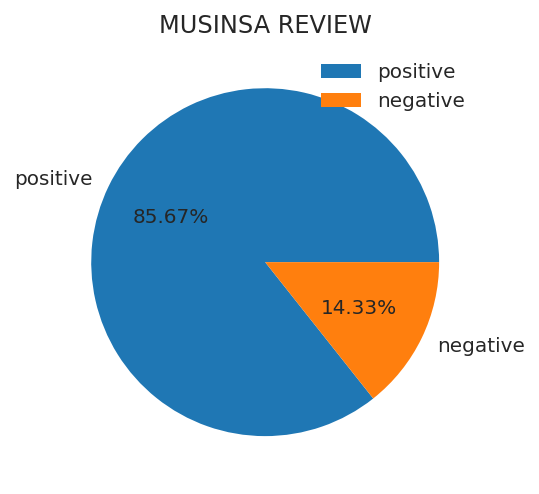

In [ ]:
# import matplotlib.pyplot as plt
labels=['positive', 'negative']

title = 'MUSINSA REVIEW'
plt.pie(ratio_list,labels=labels,autopct='%.2f%%')
plt.legend(labels)
plt.title(title)
plt.show()

In [ ]:
# plt.rc('font', family='NanumBarunGothic') 

# positive_data 를 한 배열에 모두 넣고 명사로 분리
text4 = []
text5 = []
nm=[]

# 형태소로 분리되어 리스트로 구분되어 저장되어 있는 것을 하나의 문자열로 저장
for i in range (len(positive_data)):
    text3 = ' '.join(positive_data[i])
    text4.append(text3)
text5 = ' '.join(text4)

# 저장된 문자열을 명사로 분리
nm = mecab.nouns(text5)

# Counter 명령어를 이용하여 문자당 사용된 빈도수를 계산
counter2 = Counter(nm)
available_counter2 = Counter({x: counter2[x] for x in counter2 if len(x) > 1})# 1글자 이하의 문자 제거
available_counter2.most_common(10)# 최다빈도 문자를 10개 출력
pos_real_avail=available_counter2.most_common(15)# 15개의 최다빈도 문자를 저장
#print(pos_real_avail)


positive_most_word=[]
positive_most_value=[]

#map을 이용하여 list에 묶여있는 데이터를 분리
real_avail=list(map(list,pos_real_avail))

#  word과 value를 따로 저장
for i in real_avail:
    positive_most_word.append(i[0])
    positive_most_value.append(i[1])

print(positive_most_word)
print(positive_most_value)

['사이즈', '지퍼', '생각', '후드', '구매', '오버', '만족', '가성', '기장', '마음', '기본', '두께', '가을', '가격', '추천']
[6692, 5135, 5057, 4829, 4744, 4612, 4085, 3531, 3501, 3054, 2990, 2833, 2693, 2627, 1997]


In [1]:
x1 = np.arange(len(positive_most_word))
plt.bar(x1, positive_most_value)
plt.title('positive')
plt.xticks(x1, positive_most_word)
plt.xticks(rotation=45)
plt.show()

NameError: name 'np' is not defined

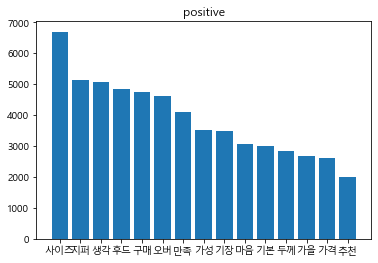

In [ ]:
# negative_data 를 한 배열에 모두 넣고 명사로 분리
text7 = []
text8 = []
bl=[]
# 형태소로 분리되어 리스트로 구분되어 저장되어 있는 것을 하나의 문자열로 저장
for i in range (len(negative_data)):
    text6 = ' '.join(negative_data[i])
    text7.append(text6)
text8 = ' '.join(text7)
print("")

# 저장된 문자열을 명사로 분리 
nl = mecab.nouns(text8)

            # Counter 명령어를 이용하여 문자당 사용된 빈도수를 계산
counter1 = Counter(nl)

# 1글자 제거
available_counter1 = Counter({x: counter1[x] for x in counter1 if len(x) > 1})# 1글자 이하의 문자 제거
available_counter1.most_common(10)# 최다빈도 문자를 10개 출력
neg_real_avail=available_counter1.most_common(15)# 15개의 최다빈도 문자를 저장
#print(neg_real_avail)

negative_most_word=[]
negative_most_value=[]

#map을 이용하여 list에 묶여있는 데이터를 분리
real_avail=list(map(list,neg_real_avail))

#  word과 value를 따로 저장
for i in real_avail:
    negative_most_word.append(i[0])
    negative_most_value.append(i[1])

print(negative_most_word)
print(negative_most_value)


['지퍼', '사이즈', '생각', '느낌', '후드', '기모', '자체', '교환', '기장', '오버', '엉덩이', '체형', '완전', '정도', '두께']
[2705, 1670, 1288, 1054, 1027, 985, 907, 705, 684, 655, 601, 581, 574, 510, 489]


In [ ]:
x2 = np.arange(len(negative_most_word))
plt.title('negative')
plt.bar(x2, negative_most_value)
plt.xticks(x2, negative_most_word)
plt.xticks(rotation=45)
plt.show()

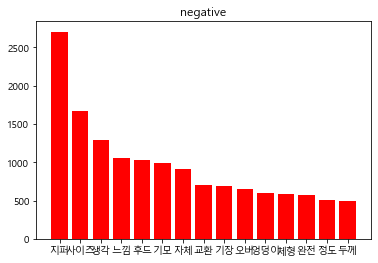

## 워드클라우드

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud
from PIL import *

wc = WordCloud(background_color='white', font_path = 'malgun.ttf', colormap='Greens' )
wc.generate_from_frequencies(positive_top_word)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

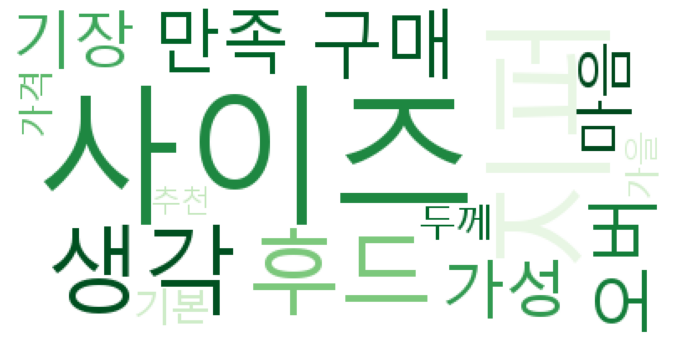

In [ ]:
wc = WordCloud(background_color='white', font_path = 'malgun.ttf', colormap='Reds' )
wc.generate_from_frequencies(negative_most_word)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

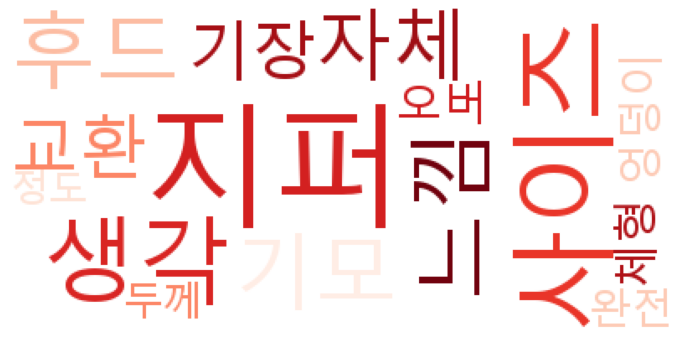

## squarify 트리맵 시각화

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import squarify
import matplotlib as mpl

norm=mpl.colors.Normalize(vmin=min(positive_top_word.values()),
                          vmax=max(positive_top_word.values()))
colors = [plt.matplotlib.cm.Blues(norm(value)) for value in positive_top_word.values()]

squarify.plot(label=positive_top_word.keys(),
              sizes=positive_top_word.values(),
              color=colors,
              alpha=.7);

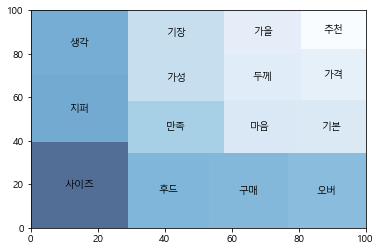

In [ ]:
norm=mpl.colors.Normalize(vmin=min(negative_most_word.values()),
                          vmax=max(negative_most_word.values()))
colors = [plt.matplotlib.cm.Reds(norm(value)) for value in negative_most_word.values()]

squarify.plot(label=negative_most_word.keys(),
              sizes=negative_most_word.values(),
              color=colors,
              alpha=.7);

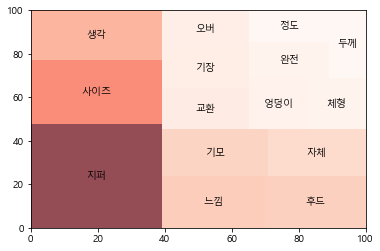